In [7]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from newsapi import NewsApiClient
from finvizfinance.screener.overview import Overview
import alpaca_trade_api as tradeapi
import datetime
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import arch
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from numpy.random import seed
seed(1)
import hvplot.pandas
from tensorflow import random
random.set_seed(2)
import pandas_datareader as pdr


In [8]:
# Read your api key environment variable
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("NEWS_API_key")
print(api_key)

6bb865f80d0a43c6b448a7a6f8181d57


In [9]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=os.environ["NEWS_API_key"])

In [10]:
foverview = Overview()

filters_dict = {
    'Performance':'Today +10%',
    'Current Volume':"Over 10M",
    'Country': 'USA'
}
foverview.set_filter(filters_dict=filters_dict)

tickers = foverview.ScreenerView()
#tickers.sort_values(by='Volume', inplace=True, ascending=False)
tickers.set_index('Ticker', inplace=True )
tickers.head(100)

,Company,Sector,Industry,Country,Market Cap,P/E,Price,Change,Volume
Ticker,,,,,,,,,
AMC,"AMC Entertainment Holdings, Inc.",Communication Services,Entertainment,USA,2.150000e+09,None,6.55,0.1491,163507362.0
ATIF,ATIF Holdings Limited,Financial,Capital Markets,USA,8.710000e+07,None,1.74,0.1226,64851207.0
CFMS,"Conformis, Inc.",Healthcare,Medical Devices,USA,2.291100e+08,None,1.24,0.1589,53018359.0
CLSN,Celsion Corporation,Healthcare,Biotechnology,USA,1.763000e+08,None,2.81,0.4789,339228064.0
CTB,Cooper Tire & Rubber Company,Consumer Cyclical,Auto Parts,USA,2.780000e+09,18.28,56.64,0.2940,10327500.0
FRX,Forest Road Acquisition Corp.,Financial,Shell Companies,USA,4.662000e+08,None,15.54,0.1060,15860037.0
GME,GameStop Corp.,Consumer Cyclical,Specialty Retail,USA,3.220000e+09,None,46.00,0.1333,19196753.0
GT,The Goodyear Tire & Rubber Company,Consumer Cyclical,Auto Parts,USA,3.860000e+09,None,16.82,0.2105,31021967.0
HL,Hecla Mining Company,Basic Materials,Gold,USA,3.410000e+09,None,6.90,0.1330,16253688.0


In [11]:
def get_sentiment(company):
    stock_headlines = ( newsapi.get_everything(
    q=company,
    language='en',
    sort_by='relevancy'))

    sentiments = []

    for articles in stock_headlines['articles']:
        try:
            text = articles['content']
            results = analyzer.polarity_scores(text)
            compound = results['compound']
            pos = results['pos']
            neu = results['neu']
            neg = results['neg'] 

            #put data into sentiments
            sentiments.append({
                'text':text,
                'Compound':compound,
                'Positive':pos,
                'Negative':neg,
                'Neutral':neu})

        except AttributeError:
            pass
    fininal_sentiments = pd.DataFrame(sentiments)
    if not fininal_sentiments.empty:
        return(fininal_sentiments["Positive"].mean())
    else:
        return(0)

In [12]:
ticker_sentiment = [] 
for ticker in tickers.index: 
    sentiment = get_sentiment(tickers['Company'][ticker])
    print(sentiment)
    if float(sentiment) >= 0.1:
        ticker_sentiment.append(ticker)
        print(f"{ticker} meets our sentiment requirement")
    else:
        print(f"{ticker} does not meet our sentiment requirement")
print(ticker_sentiment)

0.07285000000000001
AMC does not meet our sentiment requirement
0.009
ATIF does not meet our sentiment requirement
0.052750000000000005
CFMS does not meet our sentiment requirement
0.01875
CLSN does not meet our sentiment requirement
0.0662
CTB does not meet our sentiment requirement
0.07458823529411766
FRX does not meet our sentiment requirement
0.0553
GME does not meet our sentiment requirement
0.08855
GT does not meet our sentiment requirement
0.0954
HL does not meet our sentiment requirement
0.0
NBY does not meet our sentiment requirement
0.048272727272727266
PAVM does not meet our sentiment requirement
0.08338888888888889
PBCT does not meet our sentiment requirement
0.053888888888888896
RNWK does not meet our sentiment requirement
0.1056
RSVA meets our sentiment requirement
0.07483333333333332
VUZI does not meet our sentiment requirement
0.049
XELB does not meet our sentiment requirement
['RSVA']


In [13]:
### Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2",
#    base_url = "https://paper-api.alpaca.markets"
)
#account = api.get_account()
print(alpaca_api_key)

PKO52X7W2XQ1RB07P779


In [14]:
#Set time frame for reporting stocks
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days = 2) 
start_time = tomorrow.strftime("%b %d %Y") + " 10:00AM"
next_day = today + datetime.timedelta(days = 1) 
end_time = next_day.strftime("%b %d %Y") + " 1:00PM"

date_from = datetime.datetime.strptime(
    start_time, '%b %d %Y %I:%M%p')
date_to = datetime.datetime.strptime(
    end_time, '%b %d %Y %I:%M%p')

In [15]:
# Set timeframe to '1D'
timeframe = "1D"

#Set timeframe for last 2 years
start_date = pd.Timestamp("2018-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp(next_day, tz="America/New_York").isoformat()

#Get ticker data
df_ticker = api.get_barset(
    ticker_sentiment,
    timeframe,
    start=start_date,
    end=end_date
).df

df_ticker.dropna()
df_ticker.tail()


RSVA                                   
                            open     high      low  close    volume
time                                                               
2021-02-16 00:00:00-05:00  16.00  17.4000  15.9100  15.91     50814
2021-02-17 00:00:00-05:00  16.25  17.2500  16.0100  16.48     87093
2021-02-18 00:00:00-05:00  16.50  16.8799  15.6101  15.71     41349
2021-02-19 00:00:00-05:00  15.93  16.4700  15.6501  15.75     73314
2021-02-22 00:00:00-05:00  20.00  28.5000  19.0000  20.79  19847123

In [16]:
df_closing_prices = pd.DataFrame()
for ticker in ticker_sentiment: 
    df_closing_prices[ticker] = df_ticker[ticker]["close"]


In [17]:
df = pd.DataFrame()
for ticker in ticker_sentiment: 
    df.append(df_ticker[ticker].drop(columns=['high','low','volume']))
df.head()

""


In [18]:
df_closing_prices.dropna(inplace=True)
df_closing_prices.tail()

,RSVA
time,
2021-02-16 00:00:00-05:00,15.91
2021-02-17 00:00:00-05:00,16.48
2021-02-18 00:00:00-05:00,15.71
2021-02-19 00:00:00-05:00,15.75
2021-02-22 00:00:00-05:00,20.79


In [19]:
def hpfilter(ticker):
    ts_noise, ts_trend = sm.tsa.filters.hpfilter(df_ticker[ticker][['close']])

    #create different dataframes for each composition
    ticker_decomp = df_ticker[ticker][['close']].copy()
    ticker_decomp['noise'] = ts_noise
    ticker_decomp['trend'] = ts_trend
    return ts_noise.plot(title='Noise')

AxesSubplot(0.125,0.2;0.775x0.68)


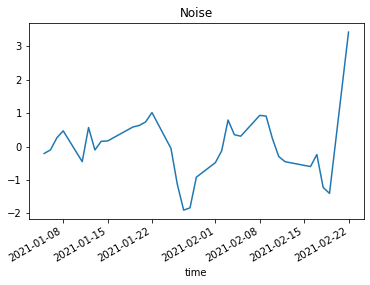

In [20]:
for ticker in ticker_sentiment: 
    print(hpfilter((ticker)))

In [21]:
price_forcasting = pd.DataFrame()
dfs=[]
for ticker in df_closing_prices: 
    model = ARIMA(df_closing_prices[ticker], order=(1,1,1))
    results = model.fit()
    df = pd.DataFrame(results.forecast(steps=15)[0], columns=[ticker])
    dfs.append(df)

final_df = pd.concat(dfs, axis=1)
final_df.head(20)

,RSVA
0,21.832784
1,21.507362
2,22.250968
3,22.159304
4,22.720266
5,22.771308
6,23.220769
7,23.358931
8,23.740322
9,23.931670


In [22]:
df = pdr.DataReader(ticker,'yahoo',start_date,end_date)[['Open','Adj Close']]


In [23]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [24]:
window_size = 5

feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

split = int(.8 * len(X))
X_train = X[:split - 1]
X_test = X[split:]
y_train = y[:split - 1]
y_test = y[split:]

In [25]:
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [26]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features
model = Sequential()
model.add(LSTM(
    units=30, return_sequences=True,
    input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summarize the model
model.summary()

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
# Train the model
# Use at least 100 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=200, shuffle=False, batch_size=1, verbose=1)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
# Make some predictions
predicted = model.predict(X_test)

# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.tail()

In [ ]:
# Plot the real vs predicted values as a line chart
stocks.head(100).hvplot()

In [ ]:
#convert to list of sticks from pandas
df_closing_list = df_closing_prices.iloc[[-1]].values.tolist()
final_df_list = final_df.iloc[[9]].values.tolist()

In [ ]:
#Gather Prices 
base_price = df_closing_list[0]
enter_price = final_df_list[0]
print(enter_price,base_price)

In [ ]:
#Figure out portfolio
stock_capital = 5000
stock_buys=[]
number_of_shares = {}
num = 0 
for ticker in df_closing_prices: 
    value = round((enter_price[num] - base_price[num])/ base_price[num] * 100.0,2)
    if value > 7:
        stock_buys.append(ticker)
        number_of_shares[ticker] = math.floor(stock_capital/enter_price[num])
    num += 1

In [ ]:
stock_capital = round(investment / len(stock_buys),2)
print(stock_capital)

In [ ]:
print(number_of_shares)